In [65]:
import requests,json,datetime
from urllib.parse import quote 
import pandas as pd
import numpy as np
import folium

In [66]:
with open('data/sub_arr_info_key.txt') as f:
    info_key = f.read()

In [67]:
df_st = pd.read_csv('data/st_addr_20230518.csv')

In [68]:
target = input('역명 입력')
target = target[:-1] if target[-1] == '역' else target

In [69]:
base_url = "http://swopenAPI.seoul.go.kr/api/subway/"
params1 = f"{info_key}/json/realtimeStationArrival/0/8/"
params2 = quote(target)
url = f"{base_url}{params1}{params2}"
response = requests.get(url)
res = json.loads(response.text)

In [70]:
df = pd.DataFrame(res['realtimeArrivalList'])
df = df[['updnLine','trainLineNm','statnNm','bstatnNm','arvlMsg2','arvlMsg3','subwayId','arvlCd']]

In [71]:
df

updnLine             trainLineNm statnNm bstatnNm            arvlMsg2   
0       상행              검암행 - 공덕방면      서울       검암               서울 출발  \
1       상행             당고개행 - 회현방면      서울      당고개               서울 도착   
2       상행  문산행 - 신촌(경의중앙선)방면 (급행)      서울  문산 (급행)               서울 도착   
3       상행             의정부행 - 시청방면      서울      의정부               서울 진입   
4       상행             의정부행 - 시청방면      서울      의정부               전역 도착   
5       상행       문산행 - 신촌(경의중앙선)방면      서울       문산      [2]번째 전역 (서강대)   
6       상행             청량리행 - 시청방면      서울      청량리  [9]번째 전역 (가산디지털단지)   
7       상행             광운대행 - 시청방면      서울      광운대       [2]번째 전역 (용산)   

  arvlMsg3 subwayId arvlCd  
0       서울     1065      2  
1       서울     1004      1  
2       서울     1063      1  
3       서울     1001      0  
4       남영     1001      5  
5      서강대     1063     99  
6  가산디지털단지     1001     99  
7       용산     1001     99

In [72]:
df1 = df[df.updnLine == '상행'].copy()
df2 = df[df.updnLine == '하행'].copy().reset_index(drop=True)

In [73]:
def kakao_location(place):
    with open('../04.지도시각화/data/kakaoapikey.txt') as f_:
        kakao_key = f_.read()
    base_url = "https://dapi.kakao.com/v2/local/search/address.json"
    url = f'{base_url}?query={quote(place)}'
    header = {'Authorization':f'KakaoAK {kakao_key}'}
    result = requests.get(url, headers=header).json()
    lat_ = float(result['documents'][0]['y'])
    lng_ = float(result['documents'][0]['x'])
    return lat_,lng_

In [74]:
def rtn_addr(target):
    str_addr = df_st[df_st.역명 == target].도로명주소.values[-1]
    return str_addr.strip()

In [75]:
temp1 =[]
for i in df1.index:
    bst = df1.arvlMsg3[i].strip()
    temp1.append(kakao_location(rtn_addr(bst)))

df_test = pd.DataFrame(temp1,columns=('lat','lng'))
df1 = pd.concat([df1, df_test], axis=1)
df1

updnLine             trainLineNm statnNm bstatnNm            arvlMsg2   
0       상행              검암행 - 공덕방면      서울       검암               서울 출발  \
1       상행             당고개행 - 회현방면      서울      당고개               서울 도착   
2       상행  문산행 - 신촌(경의중앙선)방면 (급행)      서울  문산 (급행)               서울 도착   
3       상행             의정부행 - 시청방면      서울      의정부               서울 진입   
4       상행             의정부행 - 시청방면      서울      의정부               전역 도착   
5       상행       문산행 - 신촌(경의중앙선)방면      서울       문산      [2]번째 전역 (서강대)   
6       상행             청량리행 - 시청방면      서울      청량리  [9]번째 전역 (가산디지털단지)   
7       상행             광운대행 - 시청방면      서울      광운대       [2]번째 전역 (용산)   

  arvlMsg3 subwayId arvlCd        lat         lng  
0       서울     1065      2  37.553200  126.972805  
1       서울     1004      1  37.553200  126.972805  
2       서울     1063      1  37.553200  126.972805  
3       서울     1001      0  37.553200  126.972805  
4       남영     1001      5  37.540565  126.971332  
5      서강대     1063     99  37.552705  126.934808  
6  가산디지털단지     1001     99  37.481596  126.882559  
7       용산     1001     99  37.529772  126.964742

In [76]:
temp1 =[]
for i in df2.index:
    bst = df2.arvlMsg3[i].strip()
    temp1.append(kakao_location(rtn_addr(bst)))
    
df_test = pd.DataFrame(temp1,columns=('lat','lng'))
df2 = pd.concat([df2, df_test], axis=1)
df2

Empty DataFrame
Columns: [updnLine, trainLineNm, statnNm, bstatnNm, arvlMsg2, arvlMsg3, subwayId, arvlCd, lat, lng]
Index: []

In [77]:
lat,lng = kakao_location(rtn_addr(target))
print(target,lat,lng)

서울 37.5532000173323 126.972805485095



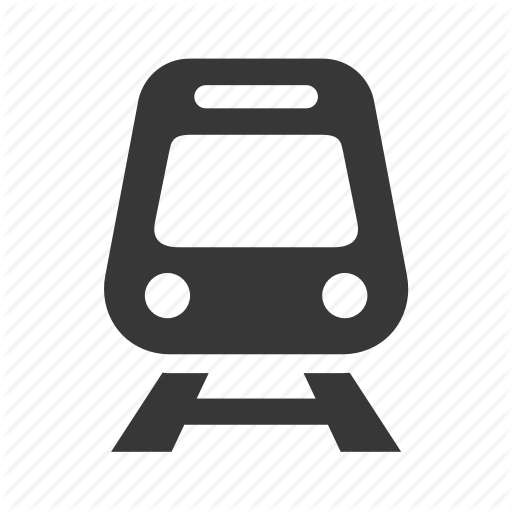
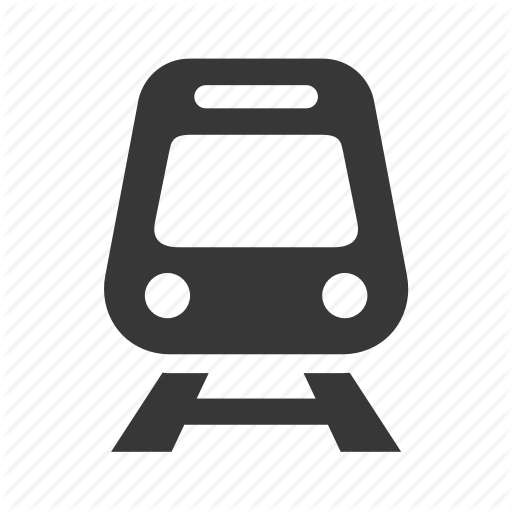
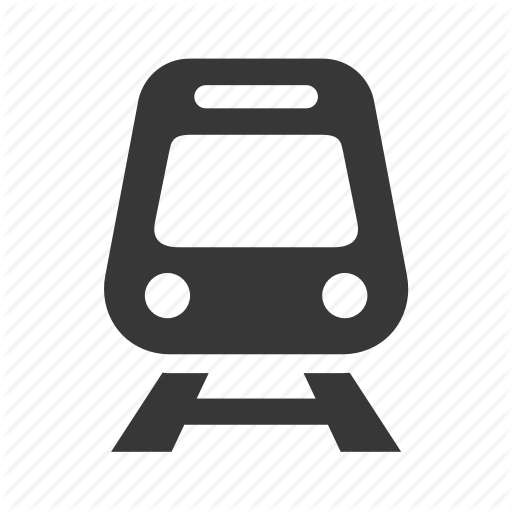
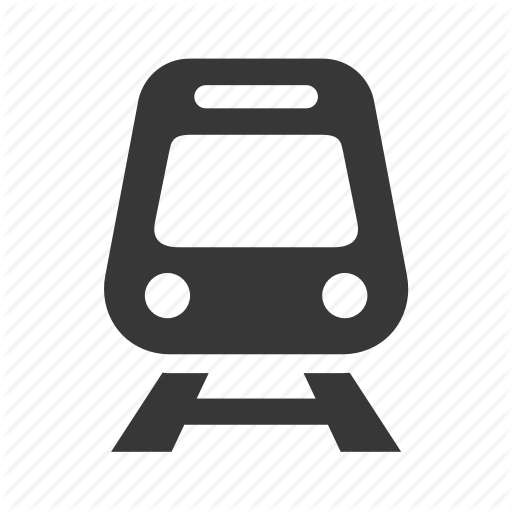
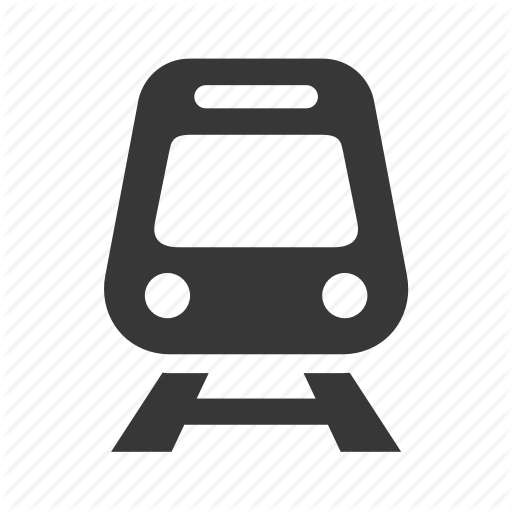
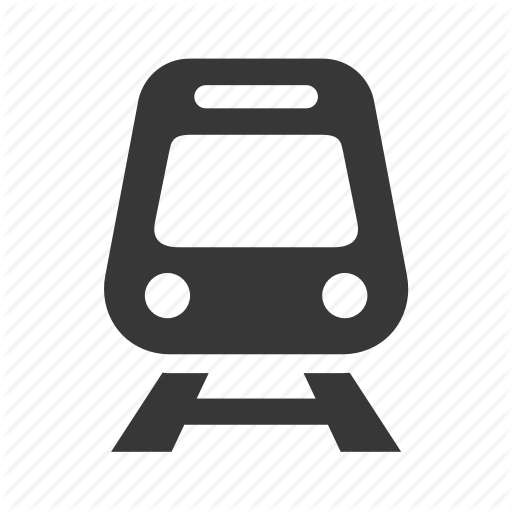
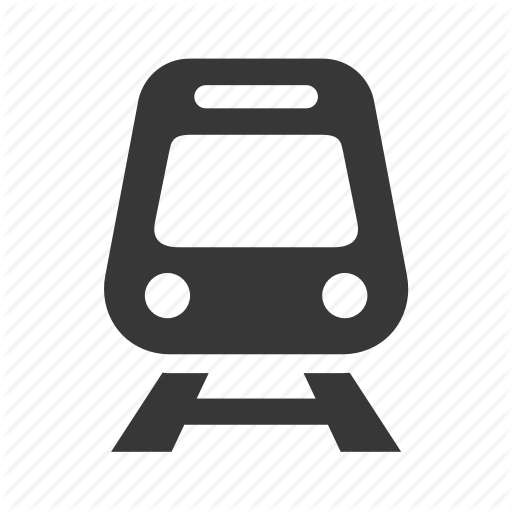
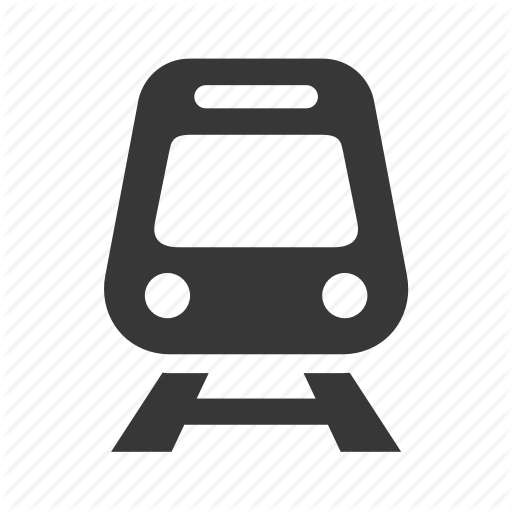

In [78]:
stn_map = folium.Map(location=[lat,lng],zoom_start=13)
for i in df1.index:
    pushpin = folium.CustomIcon(f'data/micon.jpg', icon_size=(40,40))
    folium.Marker(
        location=[df1.lat[i], df1.lng[i]],                     
        popup=folium.Popup(df1.arvlMsg2[i],max_width=300),
        tooltip=df1.arvlMsg3[i],
        icon=pushpin
    ).add_to(stn_map)
for i in df2.index:
    pushpin = folium.CustomIcon(f'data/micon.jpg', icon_size=(40,40))
    folium.Marker(
        location=[df2.lat[i], df2.lng[i]],                     
        popup=folium.Popup(df2.arvlMsg2[i],max_width=300),
        tooltip=df2.arvlMsg3[i],
        icon=pushpin
    ).add_to(stn_map)
title_html = '<h3 align="center" style="font-size:20px">지하철 실시간 도착정보</h3>'
stn_map.get_root().html.add_child(folium.Element(title_html))
stn_map

In [79]:
# 상행 하행 구분 좀더 명확하게 - x
# 노선별로 아이콘 색 다르게 - id 1000으로 나눠서 1 -> 1호선 75 -> 수인분당
# 급행도 아이콘 다르게 - x
# 검색한 역 아이콘 다르게 - 서클로?
# 어? 근데 html에서 보여주려면 .values로 꺼내야 함?
what = df2.iloc[:,:6].values

In [80]:
what

array([], shape=(0, 6), dtype=object)